In [1]:
import random
import time

from string import ascii_lowercase

import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

EPS = 1e-7

%matplotlib inline

## Dataset 

In [3]:
# Load file and take only the second column, which is called "city_ascii" - so simple city names
# Load file and take only the second column, which is called "city_ascii" - so simple city names
city_names = [row.split(",")[1].replace('"', "") for row in open("worldcities.csv").readlines()][1:]  # don't take header row
city_names[:10]


# Use code below to only use cities from a specific country
# COUNTRY_LIST = ["finland", "sweden", "norway"]
# city_names = []
# rows = [row for row in open("worldcities.csv").readlines()]
# for row in rows:
#   parts = row.split(",")
#   city = parts[1].replace('"', "")
#   country = parts[4].replace('"', "")
#   if country.lower() not in COUNTRY_LIST:
#     continue
#   else:
#     print(f"{country} -> {city}")
#   city_names.append(city.lower())
#   #city_names = city_names[1:]  # don't take header row's value
# city_names[:10]

['Tokyo',
 'Jakarta',
 'Delhi',
 'Guangzhou',
 'Mumbai',
 'Manila',
 'Shanghai',
 'Sao Paulo',
 'Seoul',
 'Mexico City']

In [4]:
# We need a special characters to denote the start and end of a city name
SPACE = " "
start_end_char = "."
allowed_chars = SPACE + ascii_lowercase
all_chars = start_end_char + allowed_chars

print(f"{ascii_lowercase=}")
print(f"{allowed_chars=}")
print(f"{all_chars=}")

print()

# Clean up the names a little bit
_cities = [name.strip().lower() for name in city_names]

# Remove characters that we don't want to allow
cities = []
for city in _cities:
    clean_city = "".join(ch for ch in city if ch in allowed_chars)
    # print(city, " -> ", clean_city)
    cities.append(clean_city)
    
# Include start/end token
# We don't start city names with "." here anymore, as the context block will be filled with them instead
# cities = [start_end_char + city + start_end_char for city in cities]
cities = [city + start_end_char for city in cities]
print(f"Cleaned up cities: \n{cities[:15]}")

# We will also allow start_end_char
num_classes = len(all_chars)
print(f"Total num valid chars = {num_classes}")

# Create simple mapping between each string char and its integer index
stoi = {c:i for i, c in enumerate(all_chars)}
itos = {i:c for c, i in stoi.items()}

print(f"{stoi=}")
print(f"{itos=}")

ascii_lowercase='abcdefghijklmnopqrstuvwxyz'
allowed_chars=' abcdefghijklmnopqrstuvwxyz'
all_chars='. abcdefghijklmnopqrstuvwxyz'

Cleaned up cities: 
['tokyo.', 'jakarta.', 'delhi.', 'guangzhou.', 'mumbai.', 'manila.', 'shanghai.', 'sao paulo.', 'seoul.', 'mexico city.', 'cairo.', 'new york.', 'dhaka.', 'beijing.', 'kolkata.']
Total num valid chars = 28
stoi={'.': 0, ' ': 1, 'a': 2, 'b': 3, 'c': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'j': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'q': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'v': 23, 'w': 24, 'x': 25, 'y': 26, 'z': 27}
itos={0: '.', 1: ' ', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'x', 26: 'y', 27: 'z'}


In [5]:
def build_dataset(words, block_size=3):
  """Create samples mapping block_size input to target character."""
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w:
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      
      context = context[1:] + [ix]
      
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

In [7]:
random.seed(34545)
random.shuffle(cities)
num_words = len(cities)
n1 = int(0.8 * num_words)
n2 = int(0.9 * num_words)

WINDOW = 8

Xtr, Ytr = build_dataset(cities[:n1], block_size=WINDOW)
Xdev, Ydev = build_dataset(cities[n1:n2], block_size=WINDOW)
Xte, Yte = build_dataset(cities[n2:], block_size=WINDOW)

torch.Size([359048, 8]) torch.Size([359048])
torch.Size([44666, 8]) torch.Size([44666])
torch.Size([44895, 8]) torch.Size([44895])


In [18]:
print("    Context    | target ")
print("------------------------")
for x, y in zip(Xtr[:15], Ytr[:15]):
  context = "".join(itos[i.tolist()] for i in x)
  target = itos[y.tolist()]
  print(f"{context:^15}|{target:^5}")

    Context    | target 
------------------------
   ........    |  p  
   .......p    |  o  
   ......po    |  r  
   .....por    |  k  
   ....pork    |  h  
   ...porkh    |  o  
   ..porkho    |  v  
   .porkhov    |  .  
   ........    |  d  
   .......d    |  a  
   ......da    |  q  
   .....daq    |  i  
   ....daqi    |  n  
   ...daqin    |  g  
   ..daqing    |  .  


## Define modules

Create building blocks that we can stack together.

Mirrors the torch API, with many simplifications.

In [89]:
class Linear:
  """Fully connected linear layer, without an activation."""
  
  def __init__(self, fan_in: int, fan_out: int, bias=True) -> None:
    """Initialise the weights of the layer"""    
    self.weight = torch.randn((fan_in, fan_out), dtype=torch.float32) / fan_in**0.5 # K.He normalisation
    self.bias = torch.zeros(fan_out) if bias else None
    
  def __call__(self, x: torch.Tensor) -> torch.Tensor:
    """Perform `y = x @ w + b`."""
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias

    return self.out
  
  def parameters(self) -> list[torch.Tensor]:
    """Provide a list of the (tensor) parameters held within this module."""
    if self.bias is None:
      return [self.weight]
    return [self.weight, self.bias]


class BatchNorm1d:
  """Batch normalisation for 1D input tensors, as per Ioffe & Szegedy.
  
  BatchNorm1 normalises a batch across the *features* of a batch. for example:
  x = [[0, 1, 2, 3, 4],
       [5, 6, 7, 8, 9],
       [7, 5, 3, 1, 0]]     shape: (3, 5) -> (batch_size, num_features)
       
  We normalise across feature_i over the batch, so for feature 0, we have: f_0 = x[:, 0]
    - f_0_mean = (0 + 5 + 7)/3
    - f_0_var = 1/3 * sum((f_0 - f_0_mean)**2)
    
  Then the normalisations step:
  
  f_0_norm = (f_0 - f_0_mean) * (f_0_var + eps)**-0.5
  
  Finally the gain (gamma) and bias (beta) parameters are brought in:
  
  f_0_out = gamma * f_0_norm + beta
  
  This is performed over all features. We also keep an exponentially weighted moving average of the mean and var.
  During inference, we do not update those numbers, but do use them instead of the inference batch's own stats.
  """
  
  def __init__(self, num_features: int, eps: float = 1e-6, momentum: float = 0.1) -> None:
    """Initialise all variables including - NOTE: this layer is stateful."""
    self.num_features = num_features
    self.eps = eps
    self.momentum = momentum
    self.training = True  # we must know in which state we are in; different behaviour in train vs inference mode
    
    # These are updated during the forward pass only, do not have gradients.
    self.running_mean = torch.zeros(num_features)
    self.running_var = torch.ones(num_features)
    # These are updated during training, forward & backward pass
    self.gamma = torch.ones(num_features)
    self.beta = torch.zeros(num_features)    
    
  def __call__(self, x: torch.Tensor) -> torch.Tensor:
    """Perform batch normalisation as per """

    if self.training:
      # Compute batch stats across the features
      # This is where we mingle statistics across samples in the batch! Not good!
      
      # Deal with both 2d and 3d inputs (just for implementation of WaveNet - otherwise consider nn.BatchNorm2D)
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0, 1)
      else:
        raise ValueError(f"Input to BatchNorm must be 2d or 3d tensor, got {x.shape}")

      bmean = x.mean(dim, keepdim=True)
      bvar = x.var(dim, keepdim=True)
      
      with torch.no_grad():
        # the initial 1d running_mean/running_var tensors are broadcasted up according to bmean and bvar.
        self.running_mean = ((1 - self.momentum) * self.running_mean) + self.momentum * bmean
        self.running_var = ((1 - self.momentum) * self.running_var) + self.momentum * bvar

    else:
      bmean = self.running_mean
      bvar = self.running_var

    xhat = (x - bmean) * (bvar + self.eps)**-0.5
    self.out = self.gamma * xhat + self.beta

    return self.out
  
  def parameters(self) -> list[torch.Tensor]:
    """Return a list of all parameters of this layer."""
    return [self.gamma, self.beta]


class Tanh:
  """Implement the element-wise tanh operation manually as a module."""
  
  def __init__(self):
    pass
  
  def __call__(self, x):
    self.out = torch.tanh(x)
    #exp_2x = torch.exp(2*x)
    #self.out = (exp_2x -1) * (exp_2x + 1)**-1
    return self.out
  
  def parameters(self):
    return []

  
class Embedding:
  """Perform the lookup of a input samples into their corresponding embedding vectors - an indexing operation."""

  def __init__(self, num_embeddings: int, embedding_dim: int) -> None:
    """Perform initialisation."""
    self.embed = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, indices: torch.Tensor) -> torch.Tensor:
    """Perform the lookup into the embedding lookup table, returning vectors corresponding to input indices"""
    self.out = self.embed[indices]
    return self.out
  
  def parameters(self):
    return [self.embed]
  

class Flatten:
  """Make a tensor 1 dimensional by `view`-ing it as such."""

  def __call__(self, x):
    return x.view(x.shape[0], -1)

  def parameters(self):
    return []

  
class FlattenConsecutive:
  """Flatten inputs into single vectors, but only for a consecutive number of elements.
  
  We are fusing together neighbouring letters into groups, then fusing those groups into bigger groups.
  This is the idea from the WaveNet paper (deepmind 2016): https://arxiv.org/pdf/1609.03499.pdf
  
  The groupings of consecutive elements are stored in a new dimension, akin to a sub-batch dimension.
  
  Example input shape:
    (batch, window, embed_dim)
  In standard flatten, we wanted to concatenate all feature elements into single vectors:
    (batch, window*embed_dim)
  Now we want to take n consecutive elements of the window, and concatenate only their features:
    (batch, window//n, embed_dim*n)  -- could also see it as:
    (batch, num_consecutive_groups, group_vector_size)
  """

  def __init__(self, n: int) -> None:
    """Initialise."""
    self.n = n

  def __call__(self, x):
    # batch, window, embed_dim
    B, T, C = x.shape
    num_groups = T // self.n
    group_emb = C * self.n
    x = x.view(B, num_groups, group_emb)
    if num_groups == 1:
      x = x.squeeze(dim=1)

    self.out = x
    return self.out

  def parameters(self):
    return []

  
class Sequential:
  """A container to hold the list of layers of a model and perform a forward pass."""
  
  def __init__(self, layers) -> None:
    """Initialise the sequntial model."""
    self.layers = layers
    
  def __call__(self, x) -> torch.Tensor:
    """Perform the forward pass through the layers of the defined sequential model."""
    for layer in self.layers:
      x = layer(x)
    self.out = x

    return self.out
    
  def zero_grads(self) -> None:
    """Set gradients of all model parameters to zero."""
    for p in self.parameters():
      p.grad = None
      
  def training_mode(self):
    """Set training flag to True on all model parameters."""
    for layer in self.layers:
      layer.training = True
      
  def inference_mode(self):
    """Set training flag to False on all model parameters."""
    for layer in self.layers:
      layer.training = False

  def parameters(self) -> int:
    """Return the parameters of the sequential class model."""
    return [p for layer in self.layers for p in layer.parameters()]

## Model

In [94]:
torch.manual_seed(739165)

n_embed = 10
n_hidden = 200
vocab_size = 28

model = Sequential(
  layers = [
    Embedding(num_embeddings=vocab_size, embedding_dim=n_embed),
    FlattenConsecutive(n=2), Linear(n_embed * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(n=2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(n=2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
  ])

with torch.no_grad():
  model.layers[-1].weight *= 0.1  # make the last layer start with low confidence on predictions
  
print(f"Total num parameters: {sum(param.numel() for param in model.parameters())}")

for p in model.parameters():
  p.requires_grad = True

Total num parameters: 171108


In [87]:
for layer in model.layers:
  print(f"{layer.__class__.__name__:<20} {tuple(layer.out.shape)}")

Embedding            (32, 8, 10)
FlattenConsecutive   (32, 4, 20)
Linear               (32, 4, 200)
BatchNorm1d          (32, 4, 200)
Tanh                 (32, 4, 200)
FlattenConsecutive   (32, 2, 400)
Linear               (32, 2, 200)
BatchNorm1d          (32, 2, 200)
Tanh                 (32, 2, 200)
FlattenConsecutive   (32, 400)
Linear               (32, 200)
BatchNorm1d          (32, 200)
Tanh                 (32, 200)
Linear               (32, 28)


## Training


Training...

[     0] loss= 3.3248				Training time:  0m  0s
[ 20000] loss= 2.4101				Training time:  0m 44s
[ 40000] loss= 2.1450				Training time:  1m 29s
[ 60000] loss= 2.2722				Training time:  2m 14s
[ 80000] loss= 2.0511				Training time:  2m 59s
[100000] loss= 2.1042				Training time:  3m 44s
[120000] loss= 1.9991				Training time:  4m 28s
[140000] loss= 1.9799				Training time:  5m 13s
[160000] loss= 1.9624				Training time:  5m 58s
[180000] loss= 2.2706				Training time:  6m 42s
[200000] loss= 1.9146				Training time:  7m 27s
[220000] loss= 2.1798				Training time:  8m 11s
[240000] loss= 1.8350				Training time:  8m 56s
[260000] loss= 1.7127				Training time:  9m 40s
[280000] loss= 1.9284				Training time: 10m 24s
[300000] loss= 2.0161				Training time: 11m  9s
[320000] loss= 2.3522				Training time: 11m 53s
[340000] loss= 1.8622				Training time: 12m 37s
[360000] loss= 1.7780				Training time: 13m 21s
[380000] loss= 1.9096				Training time: 14m  5s
[400000] loss= 1.7852				T

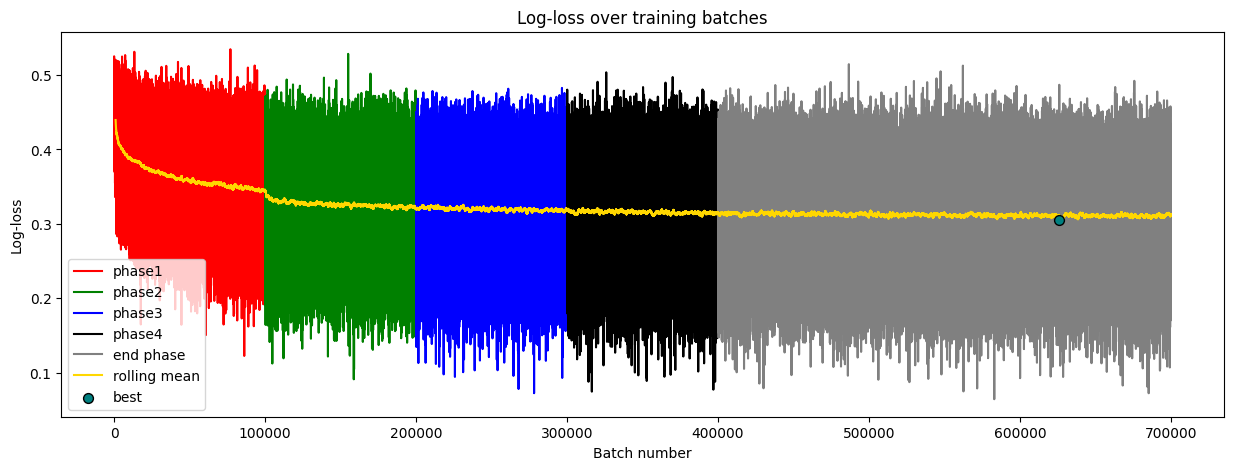

In [95]:
# Model definition ###################################################
g = torch.Generator().manual_seed(214748)

batch_size = 32
# Create an embedding tensor (latent embedding) for our characters
embedding_dim = 20
h_dim = 640
num_inputs = WINDOW * embedding_dim  # 'window' embeddings per sample + 'embedding_dim' values per embedding
  
# To track stats
losses = []
batches = []
start_time_s = time.perf_counter()

print("\nTraining...\n")

# Minibatch gradient descent
b = len(batches)
n_steps = 700_000

model.training_mode()  # ensure model is ready for training

for batch in range(b, b + n_steps):

  # Create a minibatch
  ix = torch.randint(0, Xtr.shape[0], size=(batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  logits = model(Xb)

  # compute loss
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  model.zero_grads()
  loss.backward()  # computes gradients

  # Select learning rate
  phase1 = 100_000
  phase2 = 200_000
  phase3 = 300_000
  phase4 = 400_000
  phase5 = 500_000
  # Parameter update
  nb = len(batches)
  if nb < phase1:
    lr = 0.1
  elif nb < phase2:
    lr = 0.01
  elif nb < phase3:
    lr = 0.0075
  elif nb < phase4:
    lr = 0.005
  elif nb < phase5:
    lr = 0.0025
  else:
    lr = 0.001

  # Perform weight updates
  for p in model.parameters():
    p.data += -lr * p.grad

  if batch % 20000 == 0:
    run_time_s = time.perf_counter() - start_time_s
    mins, secs = int(run_time_s // 60), int(run_time_s % 60)
    print(f"[{batch:>6}] {loss=:>7.4f}\t\t\t\tTraining time: {mins:2d}m {secs:2d}s")

  batches.append(batch)
  losses.append(loss.log10().item())

run_time_s = time.perf_counter() - start_time_s
mins, secs = int(run_time_s // 60), int(run_time_s % 60)
print(f"[{batch:>6}] {loss=:>7.4f}\t\t\t\tTraining time: {mins:2d}m {secs:2d}s")

# Plotting code
plt.figure(figsize=(15, 5))
plt.plot(batches[:phase1], losses[:phase1], c="r", label="phase1")
plt.plot(batches[phase1:phase2], losses[phase1:phase2], c="g", label="phase2")
plt.plot(batches[phase2:phase3], losses[phase2:phase3], c="b", label="phase3")
plt.plot(batches[phase3:phase4], losses[phase3:phase4], c="k", label="phase4")

if len(batches) > phase4:
  plt.plot(batches[phase4:], losses[phase4:], c="gray", label="end phase")

rolling_mean = pd.DataFrame(losses, columns=["losses"]).rolling(1000).mean()
plt.plot(batches, rolling_mean.values, c="gold", label="rolling mean")

min_loss_x, min_loss_y = torch.min(torch.tensor(rolling_mean.dropna().values), 0)
plt.scatter(min_loss_y.data.item(), min_loss_x.item(), label="best", c="teal", edgecolor="k", s=50, zorder=2)

plt.legend()
plt.xlabel("Batch number")
plt.ylabel("Log-loss")
plt.title("Log-loss over training batches");

## Metrics

In [96]:
@torch.no_grad()
def split_loss(model: Sequential, split: str) -> None:
  """Compute and print the loss of the model for the named split of the dataset: {train, val, test}."""
  x, y = {
    "train": (Xtr, Ytr),
    "val":   (Xdev, Ydev),
    "test":  (Xte, Yte),
  }[split]

  # Make sure we are not longer in training state -> inference mode for metrics
  model.inference_mode()
  logits = model(x)
  loss = F.cross_entropy(input=logits, target=y)  # Compute the loss (posed as binary classification)
  print(f"Full loss {split:<6} {loss:>8.6f}")

split_loss(model, "train")
split_loss(model, "val")
split_loss(model, "test")

# Training with 20k parameters for 500k steps  (from lecture 4 with manual backprop)
# Full loss train  2.359250
# Full loss val    2.388760
# Full loss test   2.373373

# Training with 85k parameters for 700k steps  (from lecture 4 with manual backprop)
# Full loss train  2.304820
# Full loss val    2.348817
# Full loss test   2.336866

# Training with 22k parameters for 700k steps, context window of 8 characters
# Scale up the context WINDOW length to 8 to measure baseline performance. It beats smaller cxt window above.
# Full loss train  2.236601
# Full loss val    2.313722  # overfitting
# Full loss test   2.313969
# Fixing batchnorm bug
# Full loss train  2.238288
# Full loss val    2.315836
# Full loss test   2.315711

# Implement basic WaveNet, fusing chars->bigrams, bigrams->4grams, 4grams->8grams
# Train 700k steps
# Full loss train  2.016166
# Full loss val    2.228423
# Full loss test   2.224412

Full loss train  2.016166
Full loss val    2.228423
Full loss test   2.224412


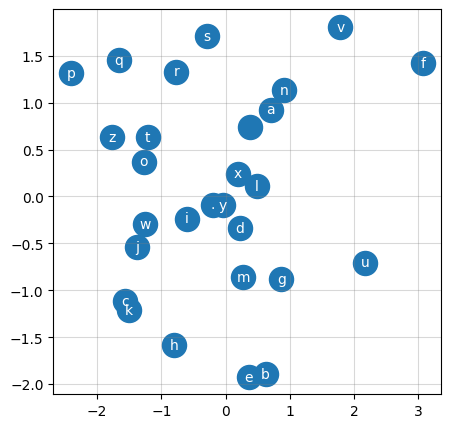

In [98]:
C = model.layers[0].embed.clone()

plt.figure(figsize=(5, 5))
plt.scatter(C[:, 0].data, C[:, 1].data, s=300)
for i in range(C.shape[0]):
  plt.text(C[i, 0].item(), C[i, 1].item(), s=itos[i], ha="center", va="center", color="white", size=10)

plt.grid(color="gray", alpha=0.3)

### Inference

In [104]:
Xb.shape, context.__len__()

(torch.Size([32, 8]), 8)

In [107]:
inputs.shape

torch.Size([8, 1])

In [108]:
for i in range(20): 
    
  ix = stoi[start_end_char]
  context = [ix] * WINDOW
  new_word = []

  while True:
    model.inference_mode()

    inputs = torch.tensor(context).view(1, -1)
    logits = model(inputs)
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
    ch = itos[ix]
    if ch == start_end_char:
      break
    new_word.append(ch)
    context = context[1:] + [ix]

  gen_city = ''.join(new_word)
  print(f"[Word {i:>2}]: {gen_city:<20} -- in dataset: {(gen_city + start_end_char) in cities}")

[Word  0]: rasco                -- in dataset: False
[Word  1]: auburu               -- in dataset: False
[Word  2]: pauripur             -- in dataset: False
[Word  3]: shahra               -- in dataset: False
[Word  4]: villa lucin          -- in dataset: False
[Word  5]: acambondur           -- in dataset: False
[Word  6]: babar                -- in dataset: True
[Word  7]: solvan               -- in dataset: False
[Word  8]: copolay              -- in dataset: False
[Word  9]: gerningcun           -- in dataset: False
[Word 10]: san mangauaptim      -- in dataset: False
[Word 11]: kaffrik              -- in dataset: False
[Word 12]: thieta               -- in dataset: False
[Word 13]: lumbidangiray        -- in dataset: False
[Word 14]: pattipah             -- in dataset: False
[Word 15]: obomiso              -- in dataset: False
[Word 16]: funise adenbaera     -- in dataset: False
[Word 17]: tirumpakuri          -- in dataset: False
[Word 18]: sel abay             -- in dataset: 